# Chapter 13: Parallel your Python
by [Arief Rahman Hakim](https://github.com/ahman24)

## 1. Parallel Computing Basics
The fundamental idea of parallel computing **is rooted in doing multiple tasks at the same time** to reduce the running time of your program. The following figure illustrates the simple idea of doing parallel computing versus serial computing that we used so far.

<img src="img/13.01.01-parallel_vs_serial.png" alt="Parallel vs Serial" width="400" />

Most of the **modern computers are using the multi-core design**, which means on **a single computing component, there are multiple independent processing units** (1 CPU consists of several physical cores). For example, there is **1 CPU processor**, with **6 physical cores** on it (see the following figure), **each of this physical cores has two logical cores**, which will bring the total number of 12 cores (see the next section when we print out the total number of CPU on your machine).

In Python, there are **two basic approaches to conduct parallel computing**, that is using the `multiprocessing` or `threading` library. Let’s first take a look of the differences of `process` and `thread`.

### 1.A Process and Thread
**A process is an instance of a program** (such as Python interpreter, Jupyter notebook etc.). A process is created by the operating system to run program, and **each process has its own memory block**. 

**A thread is a sub-process that reside within the process**. **Each process can have multiple threads**, that **these threads will share the same memory block within the process**. Therefore, for **multiple threads in a process, due to the shared memory space, the variables or objects are all shared**. 

If you change one variable in one thread, it will change for all the other threads. But things are different in different processes, change one variable in one process will not change the one in other processes. Process and thread both have advantages or disadvantages, and can be used in different tasks to maximize the benefits.



### 1.B Python’s GIL problem
Python has something called **Global Interpreter Lock (GIL)** which **allow only one native thread to run at a time**, it **prevents multiple threads from running simultaneously**. This is because Python **was designed before the multi-core processor on the personal computers** (this shows you how old the language is). Even though there are workarounds in Python to do multi-threading programming, we **will only cover the multiprocessing library** in the next section, which we will use most of the time for taking advantage of multi-core parallel computing.

### 1.C Disadvantage of using parallel computing
Of course, there are disadvantages of using parallel computing. Such as, **more complicated code, overheads when spawn new processes and maintain the process**. Thus, if your task is small, using parallel computing will take longer time, since it takes time for the system to initialize new process and maintain them.

## 2. Multiprocessing
The `multiprocessing` library is the Python’s standard library to support parallel computing using processes. It has many different features, if you want to know all the details, you can check the [official documentation](https://docs.python.org/3/library/multiprocessing.html). Here we will introduce the basics to get you start with parallel computing. Let’s start by importing the library.

In [1]:
import multiprocessing as mp

Let’s first print out the total number of CPUs that on my machine that can be used for parallel computing.

In [2]:
print(f"Number of cpu: {mp.cpu_count()}")

Number of cpu: 8


Let’s use an example to show you how to use **multiple cores** vs **one core** in one machine to reduce the time of execution time.

### 2.A SERIAL VERSION

In [3]:
import numpy as np
import time

def random_square(seed):
    np.random.seed(seed)
    random_num = np.random.randint(0, 10)
    return random_num**2

In [4]:
t0 = time.time()
results = []
for i in range(1000000): 
    results.append(random_square(i))
t1 = time.time()
print(f'Execution time {t1 - t0} s')

Execution time 6.444013833999634 s


### 2.B PARALLEL VERSION

There are 4 common methods in the class that we may use often, that is `apply`, `map`, `apply_async` and `map_async`. The simplest way to do parallel computing using the multiprocessing **is to use the Pool class**. Have a look of the documentation for the differences, and we will only use `map` function below to parallel the above example. 

The `map(func, iterable)` function takes in two arguments, and apply the function func to each element in the iterable, and then collect the results.

In [5]:
t0 = time.time()
n_cpu = mp.cpu_count()

pool = mp.Pool()
results = pool.map_async(random_square, range(1000000)) # Bug/error/unknown issues for pool.map to run indefinitely 
t1 = time.time()
print(f'Execution time {t1 - t0} s')

Execution time 0.5662727355957031 s


We can see that using the above parallel version of the code, we reduce the **run time from ~38 s to ~7 s**. This is a big gain in speed, especially if we have a heavy computation, it will reduce a lot of time by running parallel computing.

The `pool.apply` function is similar except that it can accept more arguments. The `pool.map` and `pool.apply` **will lock the main program until all the processes are finished**, which is quite useful if we want to obtain results in a particular order for some applications. In contrast, if we do not need the results in a particular order, we can also use `pool.apply_async` or `pool.map_async`, which **will submit all processes at once and retrieve the results as soon as they are finished**. Check online to learn more.



### 2.C Visualize the execution time

Let’s visualize the execution time changes versus the number of data points using both the serial and parallel version. And you will see that until certain point, it is better to use the serial version.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline

def serial(n):
    t0 = time.time()
    results = []
    for i in range(n): 
        results.append(random_square(i))
    t1 = time.time()
    exec_time = t1 - t0
    return exec_time

def parallel(n):
    t0 = time.time()
    n_cpu = mp.cpu_count()

    pool = mp.Pool(processes=n_cpu)
    results = [pool.map_async(random_square, range(n))]
    t1 = time.time()
    exec_time = t1 - t0
    return exec_time

In [7]:
n_run = np.logspace(1, 7, num = 7)

t_serial = [serial(int(n)) for n in n_run]
t_parallel = [parallel(int(n)) for n in n_run]

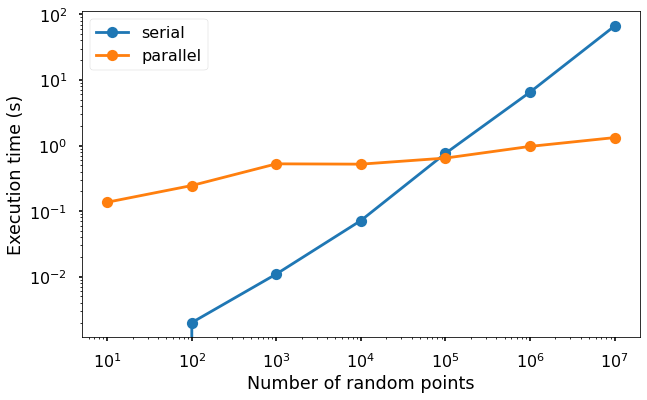

In [8]:
plt.figure(figsize = (10, 6))
plt.plot(n_run, t_serial, '-o', label = 'serial')
plt.plot(n_run, t_parallel, '-o', label = 'parallel')
plt.loglog()
plt.legend()
plt.ylabel('Execution time (s)')
plt.xlabel('Number of random points')
plt.show()

We can see from the figure that when the number of data points are small (below 10000), the execution time for the serial version is faster due to the overheads of the parallel version from launching and maintaining the new processes. But after that, we can see clearly the winner be the parallel version.

## 3. Use Joblib
In Python, there are also other 3rd party packages that can make the parallel computing easier, especially for some daily tasks. `joblib` is one of them, it provides an easy simple way to do parallel computing (it has many other usages as well).

In [9]:
from joblib import Parallel, delayed
import numpy as np

def random_square(seed):
    np.random.seed(seed)
    random_num = np.random.randint(0, 10)
    return random_num**2

In [10]:
results = Parallel(n_jobs=-1)\
    (delayed(random_square)(i) for i in range(1000000))

We can see **the parallel part of the code becomes one line** by using the `joblib library`, which is very convenient. The `Parallel` is a `helper class` that essentially **provides a convenient interface for the multiprocessing module** we saw before. The `delayed` is used **to capture the arguments of the target function**, in this case, the random_square. We run the above code with 16 CPUs, if you want to use all of computational power on your machine. You can **use all CPUs** on your machine by setting `n_jobs=-1`. If you set it to `-2`, **all CPUs but one are used**.